In [1]:
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import random
import imblearn

In [2]:
df = pd.read_csv("marketing_campaign.csv", sep=";")

In [3]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0


In [98]:
def prep_data(df, ada = False):
    #transform columns
    df.columns = df.columns.str.lower()
    df["dt_customer"] = pd.to_datetime(df["dt_customer"]).dt.year

    #filling nan's in income
    df["income"] = df["income"].fillna(df["income"].median())

    #data reliability check
    df = df.drop(columns=["id", "z_costcontact", "z_revenue"])
    df = df[df["year_birth"]>1930]
    df = df[df["income"]<200000]
    martial_ac = ["Single","Together","Married","Divorced","Widow"]
    df = df[df["marital_status"].isin(martial_ac)]

    X = df.drop(columns="response", axis=1)

    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    #one hot encoding
    encoder = OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features),index=df.index)

    #df.reset_index(drop=True, inplace=True)
    df.drop(columns=categorical_features, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

    #data split
    y = df["response"]
    X = df.drop(columns="response", axis=1)

    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2115)

    #scaling
    scaler = StandardScaler()
    x_train[numeric_features] = scaler.fit_transform(x_train[numeric_features])
    x_test[numeric_features] = scaler.transform(x_test[numeric_features])

    if ada:
        ada = imblearn.over_sampling.ADASYN(random_state=2115)
        x_train, y_train = ada.fit_resample(x_train, y_train)

    return x_train, y_train, x_test, y_test    

In [99]:
df = pd.read_csv("marketing_campaign.csv", sep=";")

In [111]:
x_train, y_train, x_test, y_test = prep_data(df, ada=True)

In [112]:
x_test

,year_birth,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,...,acceptedcmp2,complain,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow
1518,0.274268,-0.660366,1.020172,-0.933606,0.0,0.022158,-0.784663,-0.638192,-0.558826,-0.612856,...,-0.119251,-0.078789,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1730,-0.411234,-0.232904,1.020172,0.922158,0.0,-0.461751,-0.760545,-0.662701,-0.673111,-0.686627,...,-0.119251,-0.078789,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
127,-1.353800,0.115608,1.020172,0.922158,0.0,0.056723,-0.694220,-0.662701,-0.664320,-0.686627,...,-0.119251,-0.078789,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
922,0.017205,-0.563329,1.020172,-0.933606,0.0,0.609762,-0.860031,-0.172514,-0.624760,-0.649742,...,-0.119251,-0.078789,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2087,-0.839673,1.309251,-0.826494,0.922158,0.0,-1.498699,1.612056,1.126483,0.935673,1.415828,...,-0.119251,-0.078789,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,1.045459,0.208803,1.020172,0.922158,0.0,-0.841965,0.146892,-0.270552,-0.101685,-0.170234,...,-0.119251,-0.078789,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
966,0.359956,1.924557,-0.826494,-0.933606,0.0,-0.496316,1.183963,-0.148005,3.331266,-0.114907,...,-0.119251,-0.078789,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
699,-0.753985,1.245762,-0.826494,-0.933606,0.0,-0.703705,0.403145,-0.123495,0.970837,1.231402,...,-0.119251,-0.078789,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1713,-0.239859,1.336193,-0.826494,-0.933606,0.0,1.473885,0.125789,0.587276,3.379617,3.130988,...,-0.119251,-0.078789,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


2239

## make_pipeline test

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def evaluate_model(actual, predicted, class_proba):
    cm = confusion_matrix(y_true = actual, y_pred = predicted)
    acc = accuracy_score(y_true = actual, y_pred = predicted) 
    f1 = f1_score(y_true = actual, y_pred = predicted)
    sensitivity = recall_score(y_true = actual, y_pred = predicted)
    specificity = precision_score(y_true = actual, y_pred = predicted)
    fpr, tpr, threshold = roc_curve(y_test, class_proba)
    roc_auc = auc(fpr, tpr)

    return cm, acc, f1, sensitivity, specificity, fpr, tpr, roc_auc

In [3]:
def summarize_evaluation(cm, acc, f1, sensitivity, specificity, fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot = True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
    print("Accuracy reached on test data:", acc)
    print("F1 score reached on test data:", f1)
    print("Sensitivity reached on test data:", sensitivity)
    print("Specificity reached on test data:", specificity)
    plt.figure(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv("marketing_campaign.csv", sep = ";")
X = data.drop("Response", axis=1)
y = data["Response"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2115)

In [42]:
pd.set_option('display.max_columns', None)
X_train.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,5,48,6,10,7,3,2,1,4,6,0,0,0,0,0,0,3,11
2030,3945,1947,PhD,Widow,68117.0,0,1,2013-03-10,80,618,44,215,0,17,36,2,11,8,4,6,1,0,0,0,0,0,3,11
830,4887,1976,PhD,Divorced,55412.0,1,1,2013-11-22,65,10,5,28,11,1,8,1,2,0,3,5,0,0,0,0,0,0,3,11
2160,5667,1964,PhD,Married,60896.0,0,1,2012-10-11,90,1013,30,399,60,46,153,3,9,10,4,6,0,0,0,0,0,0,3,11
1166,6116,1968,2n Cycle,Married,48985.0,0,1,2013-07-05,13,19,13,18,10,7,8,1,1,1,3,3,0,0,0,0,0,0,3,11


In [43]:
X_train["Dt_Customer"]

48      2014-01-01
2030    2013-03-10
830     2013-11-22
2160    2012-10-11
1166    2013-07-05
           ...    
1641    2013-09-23
194     2013-02-18
757     2013-09-19
879     2013-01-17
987     2013-10-25
Name: Dt_Customer, Length: 1792, dtype: object

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class YearFromDtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is a DataFrame and "Dt_Customer" is one of its columns
        year_column = X["Dt_Customer"].str[:4].astype(int)
        return year_column.values.reshape(-1, 1)

In [7]:
X_train["Dt_Customer"].str[:4].astype(int).values.reshape(-1, 1)

array([[2014],
       [2013],
       [2013],
       ...,
       [2013],
       [2013],
       [2013]])

In [8]:
X_train["Year_Birth"][X_train["Year_Birth"]>1930].values.reshape(-1, 1)

array([[1951],
       [1947],
       [1976],
       ...,
       [1964],
       [1978],
       [1969]], dtype=int64)

In [50]:
X["Year_Birth"].loc[X["Year_Birth"]>1930].values.reshape(-1, 1).shape

(2237, 1)

In [7]:
class RemoveDumbYearBirth(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.median_year_birth = X["Year_Birth"].median().astype(int)
        return self
    
    def transform(self, X):
        X.loc[X["Year_Birth"]<1930, "Year_Birth"] = self.median_year_birth
        return X["Year_Birth"].values.reshape(-1, 1)

In [27]:
X.loc[X["Year_Birth"]<1930] = int(X["Year_Birth"].median())

In [28]:
X.loc[X["Year_Birth"]<1930]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue


In [11]:
X_train["Income"][X_train["Income"]<200000].values.reshape(-1, 1)

array([[68117.],
       [55412.],
       [60896.],
       ...,
       [58512.],
       [17117.],
       [75759.]])

In [8]:
class RemoveDumbIncome(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.median_income = X["Income"].median().astype(int)
        return self
    
    def transform(self, X):
        X.loc[X["Income"]>200000, "Income"] = self.median_income
        return X["Income"].values.reshape(-1, 1)

In [20]:
X.loc[X["Income"]>200000]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,...,3,6,0,0,0,0,0,0,3,11


In [9]:
categories = {
        'education': X_train['Education'].unique(),
        'martial_status': X_train['Marital_Status'].unique(),
        'kidhome': X_train["Kidhome"].unique(),
        'teenhome': X_train["Teenhome"].unique(),
        'acceptedcmp1': X_train["AcceptedCmp1"].unique(),
        'acceptedcmp2': X_train["AcceptedCmp2"].unique(),
        'acceptedcmp3': X_train["AcceptedCmp3"].unique(),
        'acceptedcmp4': X_train["AcceptedCmp4"].unique(),
        'acceptedcmp5': X_train["AcceptedCmp5"].unique()
    }

In [30]:
X_train.select_dtypes(include=['number']).columns.tolist()

['ID',
 'Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue']

In [14]:
col_to_drop = 

In [10]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from skopt import BayesSearchCV

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', ["ID", "Z_CostContact", "Z_Revenue"]),
        ('year_dt', YearFromDtTransformer(), ["Dt_Customer"]),
        ('dumb_year_birth', RemoveDumbYearBirth(), ["Year_Birth"]),
        ('dumb_income', RemoveDumbIncome(), ["Income"]),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [ ]:
"""        ('dumb_year_birth', RemoveDumbYearBirth(), ["Year_Birth"]),
        ('dumb_income', RemoveDumbIncome(), ["Income"])"""

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from GPyOpt.methods import BayesianOptimization
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

def pipeline_cv_score(parameters):
    parameters = parameters[0]
    # Construct the pipeline with given hyperparameters
    pipeline = Pipeline([('preprocessor', preprocessor),
        ('imputer', SimpleImputer(strategy="median")),
        ('sampling', ADASYN()),  # Your preprocessor pipeline
        ('classifier', xgb.XGBClassifier(
            max_depth=int(parameters[0]),
            min_child_weight=int(parameters[1]),
            subsample=parameters[2],
            colsample_bytree=parameters[3],
            n_estimators=int(parameters[4]),
            learning_rate=parameters[5],
            random_state=2115))
    ])
    # Evaluate the pipeline using cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring=make_scorer(precision_score), cv=5).mean()
    return score

# Define the search space for Bayesian optimization
bayesian_opt_bounds = [
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 15)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 5, 10)},
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.5, 1.0)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 200, 300, 400)},
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.01, 0.2)}
]
# Initialize and run Bayesian optimization
optimizer = BayesianOptimization(
	f=pipeline_cv_score, domain=bayesian_opt_bounds, model_type='GP',
	acquisition_type='EI', max_iter=25
    )
optimizer.run_optimization()

# Get the best parameters
best_params_bayesian = optimizer.x_opt

# Initialize and train the model with the best parameters
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        max_depth=int(best_params_bayesian[0]),
        min_child_weight=int(best_params_bayesian[1]),
        subsample=best_params_bayesian[2],
        colsample_bytree=best_params_bayesian[3],
        n_estimators=int(best_params_bayesian[4]),
        learning_rate=best_params_bayesian[5],
        random_state=2115
    ))
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('column_dropper', 'drop',
                                                  ['ID', 'Z_CostContact',
                                                   'Z_Revenue']),
                                                 ('year_dt',
                                                  YearFromDtTransformer(),
                                                  ['Dt_Customer']),
                                                 ('dumb_year_birth',
                                                  RemoveDumbYearBirth(),
                                                  ['Year_Birth']),
                                                 ('dumb_income',
                                                  RemoveDumbIncome(),
                                                  ['Income']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.14143317568550642, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=10,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=2115, ...))])

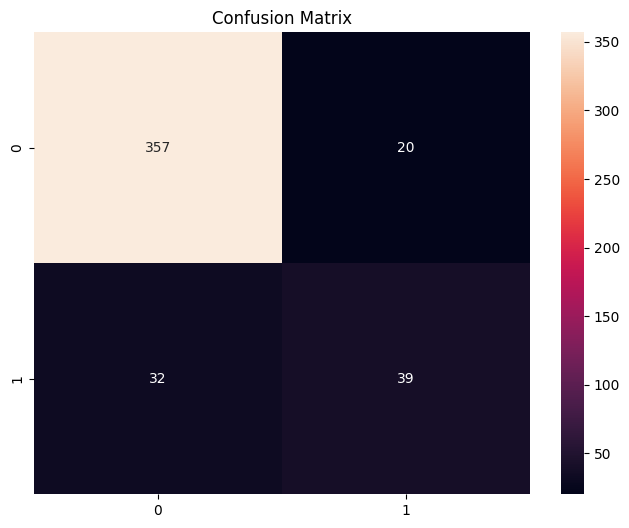

Accuracy reached on test data: 0.8839285714285714
F1 score reached on test data: 0.6
Sensitivity reached on test data: 0.5492957746478874
Specificity reached on test data: 0.6610169491525424


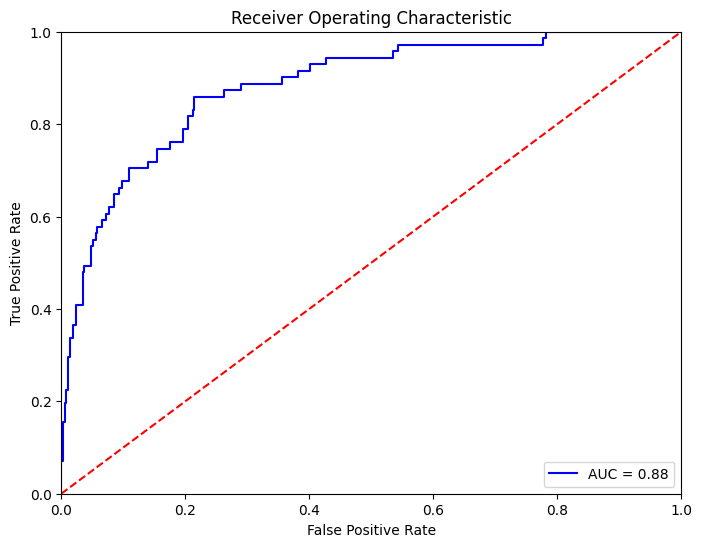

In [13]:
dummy_pred = best_pipeline.predict(X_test)
class_probabilities = best_pipeline.predict_proba(X_test)
dummy_proba = class_probabilities[:, 1]
dummy_cm, dummy_acc, dummy_f1, dummy_sensitivity, dummy_specificity, dummy_fpr, dummy_tpr, dummy_roc_auc = evaluate_model(y_test, dummy_pred, dummy_proba)
summarize_evaluation(dummy_cm, dummy_acc, dummy_f1, dummy_sensitivity, dummy_specificity, dummy_fpr, dummy_tpr, dummy_roc_auc)

In [41]:
import pickle
pickle.dump(best_pipeline, open('models/xgb_v2.pkl','wb'))

In [39]:
best_params_bayesian

array([3.00000000e+00, 5.00000000e+00, 8.28159109e-01, 9.18372095e-01,
       4.00000000e+02, 1.90810240e-02])

In [37]:
optimizer

In [32]:
bayesian_opt_bounds[0]["domain"]

(3, 10, 15)

In [11]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)
grid_search = RandomizedSearchCV(clf, random_grid, n_jobs=-1, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8772321428571429

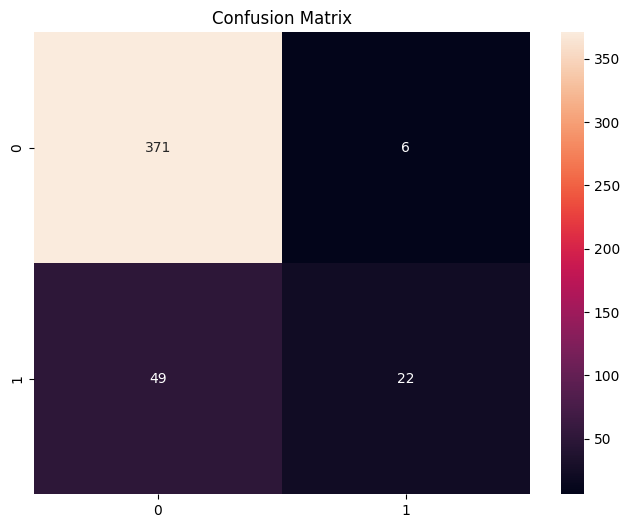

Accuracy reached on test data: 0.8772321428571429
F1 score reached on test data: 0.4444444444444444
Sensitivity reached on test data: 0.30985915492957744
Specificity reached on test data: 0.7857142857142857


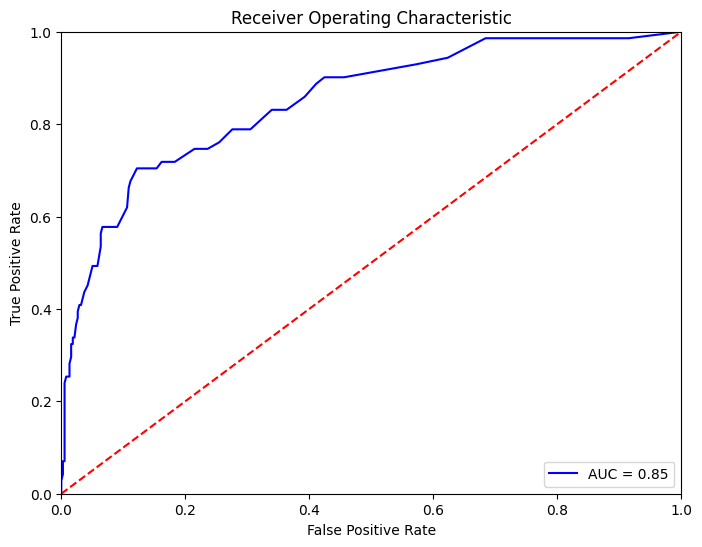

In [15]:
dummy_pred = clf.predict(X_test)
class_probabilities = clf.predict_proba(X_test)
dummy_proba = class_probabilities[:, 1]
dummy_cm, dummy_acc, dummy_f1, dummy_sensitivity, dummy_specificity, dummy_fpr, dummy_tpr, dummy_roc_auc = evaluate_model(y_test, dummy_pred, dummy_proba)
summarize_evaluation(dummy_cm, dummy_acc, dummy_f1, dummy_sensitivity, dummy_specificity, dummy_fpr, dummy_tpr, dummy_roc_auc)

In [16]:
preprocess = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(categories=[categories.get(col, 'auto') for col in categorical_features]), categorical_features))

In [19]:
pipe = make_pipeline(
    preprocess,
    RandomForestClassifier(random_state = 2115)
)

In [23]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ohc', OneHotEncoder()),
    ('rf', RandomForestClassifier(random_state = 2115))
]

)

In [24]:
pipe.fit(X_train, y_train)

ValueError: could not convert string to float: 'Graduation'

In [70]:
xd = pipe.fit_transform(df)

In [72]:
pd.DataFrame(xd)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.985345,0.234063,-0.825218,-0.929894,-1.502225,0.307039,0.983781,1.551577,1.679702,2.462147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.235733,-0.234559,1.032559,0.906934,1.420036,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.317643,0.769478,-0.825218,-0.929894,-0.041094,-0.798086,0.362723,0.570804,-0.177032,1.345274,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.268149,-1.017239,1.032559,-0.929894,1.420036,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.017761,0.240221,1.032559,-0.929894,1.420036,1.550305,-0.389085,0.419916,-0.216914,0.155164,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.150717,0.356642,-0.825218,0.906934,-0.041094,-0.107383,1.203678,0.419916,0.066692,0.081926,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2236,-1.903435,0.467539,2.890335,0.906934,1.420036,0.237969,0.303291,-0.661449,-0.606873,-0.687068,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,1.017761,0.188091,-0.825218,-0.929894,1.420036,1.446700,1.795020,0.545656,0.221789,-0.101168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2238,-1.068807,0.675388,-0.825218,0.906934,1.420036,-1.419719,0.368666,0.092992,0.208495,0.777683,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
